# Notebook for performing Mann-Whitney U-tests for statistical significance

### Import stats libraries, namely mannwhitney package from scipy.stats

In [20]:
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import mannwhitneyu
import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np

## Import WRF daily max files (resampled to convective daily max) for each climate epoch

In [21]:
wrf_hist = xr.open_dataset('/home/scratch/jgoodin/convective_daily_max_resamples/hist_daily_max_hail_inches.nc')
wrf_mid4p5 = xr.open_dataset('/home/scratch/jgoodin/convective_daily_max_resamples/mid_century_4p5_daily_max_hail_inches.nc')
wrf_mid8p5 = xr.open_dataset('/home/scratch/jgoodin/convective_daily_max_resamples/mid_century_8p5_daily_max_hail_inches.nc')
wrf_end4p5 = xr.open_dataset('/home/scratch/jgoodin/convective_daily_max_resamples/end_century_4p5_daily_max_hail_inches.nc')
wrf_end8p5 = xr.open_dataset('/home/scratch/jgoodin/convective_daily_max_resamples/end_century_8p5_daily_max_hail_inches.nc')

In [22]:
wrf_hist

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

## Pass hail day threshold

In [23]:
hist_sev = 1 * (wrf_hist >= 0.0254)

In [24]:
mid4p5_sev = 1 * (wrf_mid4p5 >= 0.0254)

In [25]:
mid8p5_sev = 1 * (wrf_mid8p5 >= 0.0254) #Can change threshold to larger hail as well

In [26]:
end4p5_sev = 1 * (wrf_end4p5 >= 0.0254)

In [27]:
end8p5_sev = 1 * (wrf_end8p5 >= 0.0254)

In [28]:
hist_sev.HAIL_MAX2D.shape

(5479, 899, 1399)

### Resample by year and sum along the 'Time' dimension- provides a count of yearly sev hail days

In [29]:
hist_annual = hist_sev.groupby('Time.year').sum(dim = 'Time')
mid4p5_annual = mid4p5_sev.groupby('Time.year').sum(dim = 'Time')
mid8p5_annual = mid8p5_sev.groupby('Time.year').sum(dim = 'Time') #Groupby year and sum sev days across time dim to provide annual sev hail day count
end4p5_annual = end4p5_sev.groupby('Time.year').sum(dim = 'Time') #Can change to seasonal as well
end8p5_annual = end8p5_sev.groupby('Time.year').sum(dim = 'Time')

In [31]:
mid8p5_annual

<xarray.Dataset>
Dimensions:     (year: 16, south_north: 899, west_east: 1399)
Coordinates:
  * year        (year) int64 2040 2041 2042 2043 2044 ... 2052 2053 2054 2055
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (year, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

### Select array containing HAIL_MAX2D values to send into Mann-Whitney

In [ ]:
"""
hist_annual = hist_annual.HAIL_MAX2D
mid4p5_annual = mid4p5_annual.HAIL_MAX2D
mid8p5_annual = mid8p5_annual.HAIL_MAX2D #Select values (2D array) of HAIL_MAX2D to pass to Mann-Whitney U-test
end4p5_annual = end4p5_annual.HAIL_MAX2D
end8p5_annual = end8p5_annual.HAIL_MAX2D
"""

In [ ]:
#hist_annual.shape #Make sure shape is 2D

## Import netcdf file containing lat/lon coords for WRF files

In [33]:
coords = xr.open_dataset('lat_lon.nc') #Open .nc file containing WRF lat/lon coords

### Assign lat/lon coords from file to variables

In [34]:
lats = coords.CLAT.values[0, :, :]
lons = coords.CLONG.values[0, :, :]

In [35]:
lons.shape

(899, 1399)

## Perform Mann-Whitney U-test for medians (means?), incorporating false-discovery rate correction

In [60]:
def field_significance(hist_annual, end8p5_annual):
    
    #sets up p-value array (default 1 - not significant)
    results = np.ones(shape=(hist_annual.HAIL_MAX2D.shape[1], hist_annual.HAIL_MAX2D.shape[2]), dtype=float)
    
    #loop through the y and x dimensions
    for i in range(hist_annual.HAIL_MAX2D.shape[1]):
        for j in range(hist_annual.HAIL_MAX2D.shape[2]):
            
            dist1 = hist_annual.HAIL_MAX2D[:, i, j]
            dist2 = end8p5_annual.HAIL_MAX2D[:, i, j]
            
            try:
                s, p = mannwhitneyu(dist1, dist2)
                results[i, j] = p
            except Exception as e:
                results[i, j] = np.nan
            
    return results

#Send your arrays into 'field_significance' function, sample below
res = field_significance(hist_annual, end8p5_annual)
#clip to your region if needed
#res_mask = np.ma.masked_where(clip==False, res).filled(np.nan)
#flat_max = mask_fin[0].values.flatten()

#Perform the false discovery rate test
p = multipletests(res.flatten(), alpha=0.1, method='fdr_bh')[0]

#Save output
np.save('/home/scratch/jgoodin/fdr_delta_hist_end8p5_annual_sev_hail_days.npy',p.reshape((lons.shape)))

## Open numpy array created above and check contents

In [61]:
hist_mid4p5_utest = np.load('/home/scratch/jgoodin/fdr_delta_hist_end8p5_annual_sev_hail_days.npy')

In [62]:
hist_mid4p5_utest.dtype

dtype('bool')

In [63]:
hist_mid4p5_utest.shape

(899, 1399)

In [64]:
print(np.sum(hist_mid4p5_utest)) #This is an easy way to sum up # of 'True' grids (for booleans 0 = False and 1 = True)

388100


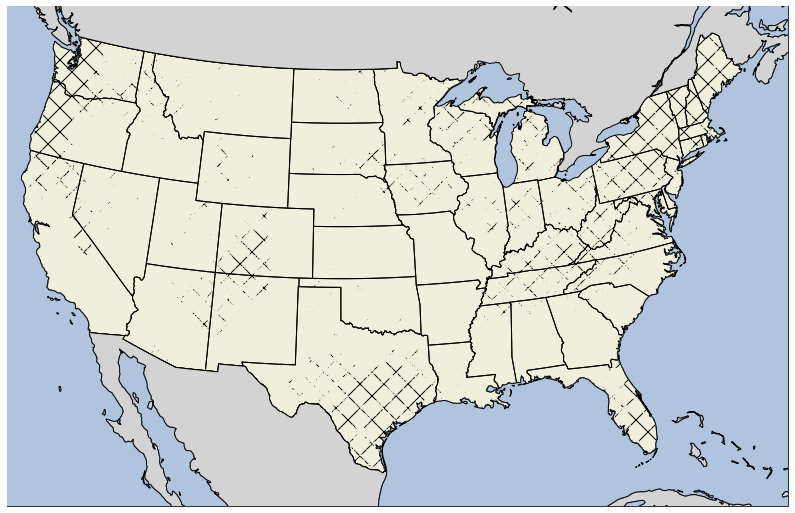

In [65]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize= (14,10)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
#ax.set_title('Maximum diameter hail for 2005', fontsize = 22)
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
ax.set_extent([240,287,22,50]) #Set lat/lon boundaries
#lrFig = ax.pcolormesh(lons, lats, hist_mid4p5_utest, cmap = 'PRGn', transform = ccrs.PlateCarree())
data = np.ma.masked_equal(hist_mid4p5_utest, 0)
ax.contourf(lons, lats, data, color = 'none', hatches = 'X', edgecolor = 'b', transform=ccrs.PlateCarree(), alpha = 0)
#gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="solid", zorder = 10)
#gls.top_labels=False
#gls.right_labels=False
#gls.xlabel_style = {'size': 30, 'rotation': 0}
#gls.xpadding = 12.0
#gls.ylabel_style = {'size': 30}
#plt.title("Mean Days ≥ 1 in (END 4.5)", fontsize = 50)
#ax1 = plt.subplot(gs1[1, 0])
#cb = plt.colorbar(lrFig, cax = ax1, orientation = 'horizontal', extend = 'max')
#cb.set_label('Days', fontsize = 30)
#cb.ax.tick_params(labelsize = 38)
plt.subplots_adjust(bottom=0.02)